## **Importing required libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import missingno
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# **Importing Datasets**

In [ ]:
yield_data_path = '/content/yield.csv'
temp_data_path = '/content/temp.csv'
rainfall_data_path = '/content/rainfall.csv'
pesticides_data_path = '/content/pesticides.csv'
yield_df_path = '/content/yield_df.csv'

try:
    yield_data = pd.read_csv(yield_data_path)
    temp_data = pd.read_csv(temp_data_path)
    rainfall_data = pd.read_csv(rainfall_data_path)
    pesticides_data = pd.read_csv(pesticides_data_path)
    yield_df = pd.read_csv(yield_df_path)

except FileNotFoundError as e:
    print(f"Error: {e}")


# **Understanding Data**

**Yield Data**

In [ ]:
yield_data.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260


In [ ]:
yield_data = yield_data[['Area','Item','Year','Value']]

In [ ]:
yield_data.head(3)

,Area,Item,Year,Value
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260


In [ ]:
yield_data.shape

(56717, 4)

**Temperature Data**

In [ ]:
temp_data.rename(columns = {'year':'Year','country':'Area'}, inplace = True)
temp_data.head(3)

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67


In [ ]:
temp_data.shape

(71311, 3)

**Rainfall Data**

In [ ]:
rainfall_data.head(3)

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327


In [ ]:
rainfall_data.shape

(6727, 3)

**Pesticides Data**

In [ ]:
pesticides_data.head(3)

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0


In [ ]:
pesticides_data = pesticides_data[['Area','Year','Value']]

In [ ]:
pesticides_data.head(2)

,Area,Year,Value
0,Albania,1990,121.0
1,Albania,1991,121.0


In [ ]:
pesticides_data.shape

(4349, 3)

**Merging Datasets and Preprocessing**

In [ ]:
temp_data = temp_data[temp_data['Year'] >= 1961]

f_yield = pd.merge(yield_data, temp_data, on=['Year', 'Area'])
f_yield = pd.merge(f_yield, pesticides_data, on=['Year', 'Area'])
f_yield.rename(columns={'Value_x': 'Yield_Value', 'Value_y': 'Pesticides_Value'}, inplace=True)

rainfall_data.rename(columns={' Area': 'Area', 'average_rain_fall_mm_per_year': 'average_rain'}, inplace=True)
rainfall_data['average_rain'] = pd.to_numeric(rainfall_data['average_rain'], errors='coerce')

f_yield = pd.merge(f_yield, rainfall_data, on=['Year', 'Area'])
df = f_yield = f_yield[['Area','Item','Year','avg_temp','Pesticides_Value','average_rain','Yield_Value']]

f_yield.head(3)


,Area,Item,Year,avg_temp,Pesticides_Value,average_rain,Yield_Value
0,Albania,Maize,1990,16.37,121.0,1485.0,36613
1,Albania,Potatoes,1990,16.37,121.0,1485.0,66667
2,Albania,"Rice, paddy",1990,16.37,121.0,1485.0,23333


In [ ]:
f_yield = f_yield.dropna()
f_yield.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              28242 non-null  object 
 1   Item              28242 non-null  object 
 2   Year              28242 non-null  int64  
 3   avg_temp          28242 non-null  float64
 4   Pesticides_Value  28242 non-null  float64
 5   average_rain      28242 non-null  float64
 6   Yield_Value       28242 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


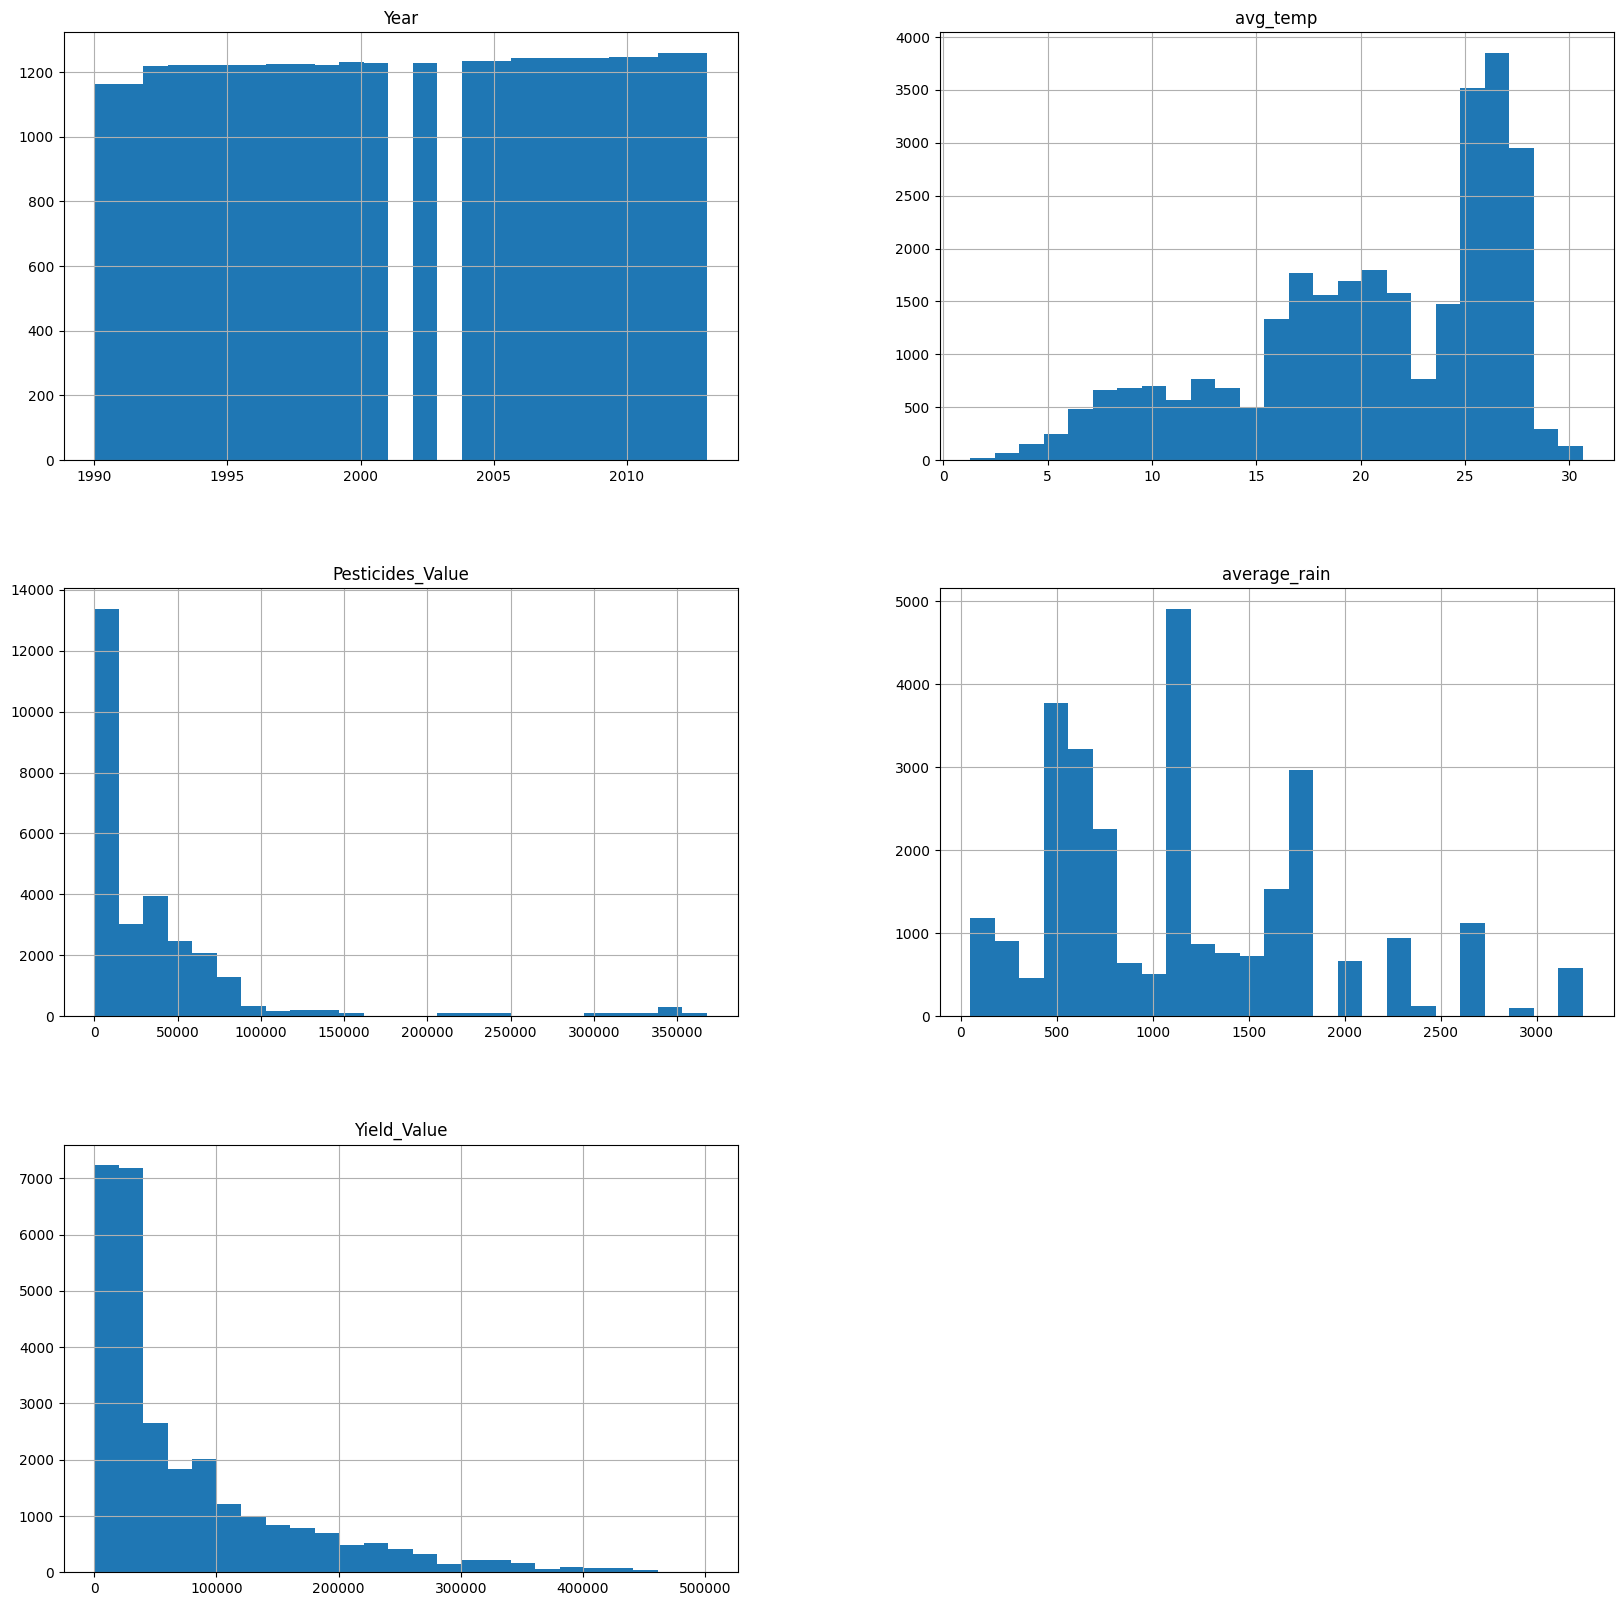

In [ ]:
f_yield.hist(bins = 25,figsize=(20,20));

**Tail adjustment**

In [ ]:
f_yield["Pesticides_Value"] = np.log1p(f_yield["Pesticides_Value"])

<ipython-input-19-d3ad6e95b3f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_yield["Pesticides_Value"] = np.log1p(f_yield["Pesticides_Value"])


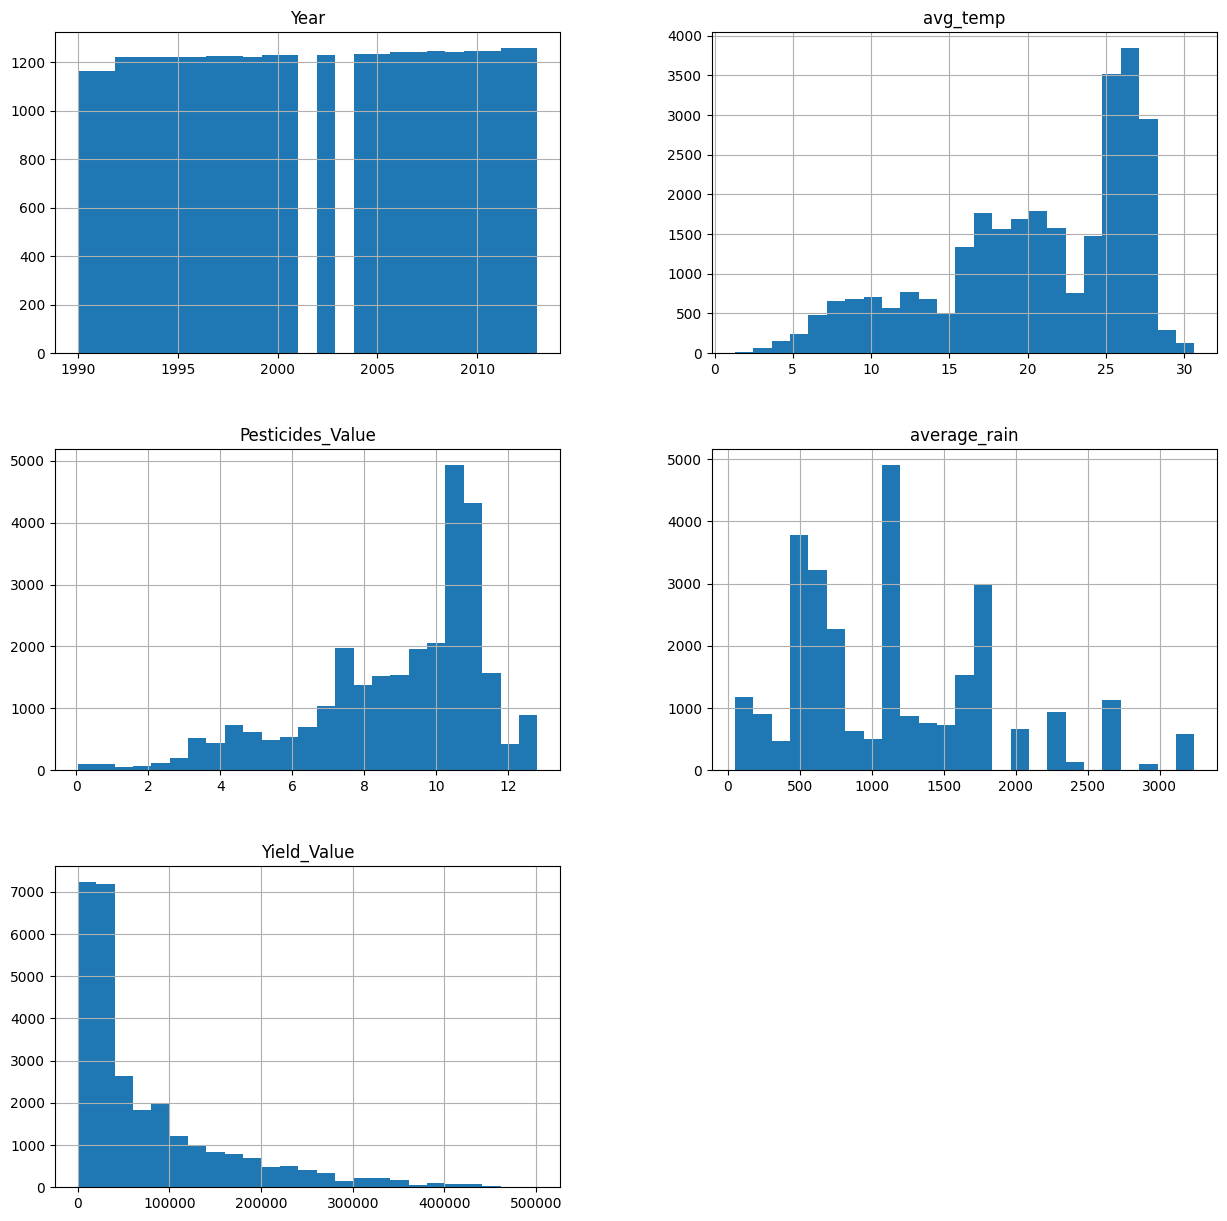

In [ ]:
f_yield.hist(bins = 25,figsize=(15,15));

In [ ]:
f_yield['rain_temp'] = f_yield['avg_temp'] * f_yield['average_rain']
f_yield['Pesticides_rain'] = np.log(f_yield['Pesticides_Value'] / f_yield['average_rain'])
f_yield['Pesticides_temp'] = np.log(f_yield['Pesticides_Value'] / f_yield['avg_temp'])
f_yield['Pesticides_temp_rain'] = (f_yield['Pesticides_temp'] / f_yield['Pesticides_rain'])
f_yield['rain_log'] = np.log(f_yield['average_rain'])
f_yield['temp_rainlog'] = f_yield['avg_temp'] / f_yield['rain_log']

num_cols = ['avg_temp', 'Pesticides_Value', 'average_rain', 'rain_temp', 'Pesticides_rain',
            'Pesticides_temp', 'Pesticides_temp_rain', 'rain_log', 'temp_rainlog', 'Yield_Value']

correlation_matrix = f_yield[num_cols].corr()
correlation_sorted = correlation_matrix["Yield_Value"].sort_values(ascending=False)

correlation_sorted

In [ ]:
correlation_of_data = f_yield.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = correlation_of_data.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()
for column in categorical_columns:
    correlation_of_data[column] = label_encoder.fit_transform(correlation_of_data[column])

correlation_of_data.head(3)

,Area,Item,Year,avg_temp,Pesticides_Value,average_rain,Yield_Value,rain_temp,Pesticides_rain,Pesticides_temp,Pesticides_temp_rain,rain_log,temp_rainlog
0,0,1,1990,16.37,4.804021,1485.0,36613,24309.45,-5.733717,-1.225997,0.213822,7.30317,2.241492
1,0,3,1990,16.37,4.804021,1485.0,66667,24309.45,-5.733717,-1.225997,0.213822,7.30317,2.241492
2,0,4,1990,16.37,4.804021,1485.0,23333,24309.45,-5.733717,-1.225997,0.213822,7.30317,2.241492


<Axes: >

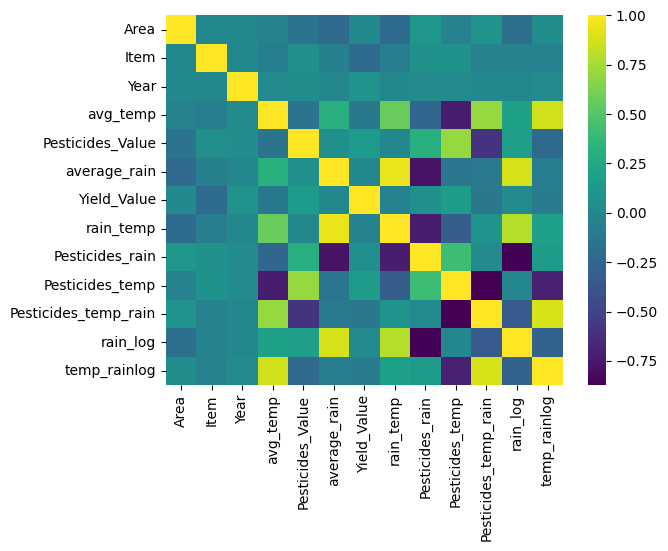

In [ ]:
sns.heatmap(correlation_of_data.corr(), cmap='viridis')

In [ ]:
correlation_matrix = correlation_of_data.corr()
correlation_matrix["Yield_Value"].sort_values(ascending=False)

Yield_Value             1.000000
Pesticides_temp         0.158125
Pesticides_Value        0.147451
Year                    0.091630
Pesticides_rain         0.054329
rain_log                0.012999
Area                    0.006672
average_rain            0.000962
rain_temp              -0.044928
temp_rainlog           -0.102357
avg_temp               -0.114777
Pesticides_temp_rain   -0.126820
Item                   -0.225103
Name: Yield_Value, dtype: float64

In [ ]:
correlation_of_data["Yield_Value_Cat"] = pd.cut(correlation_of_data["Yield_Value"],
 bins=[0.,30000, 100000,250000, 350000.,np.inf],
 labels=[1, 2, 3, 4, 5])

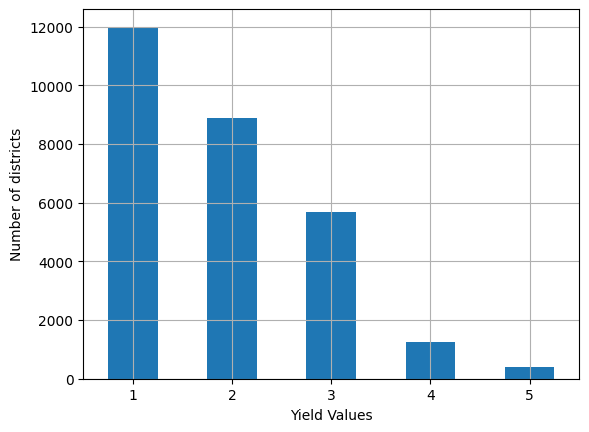

In [ ]:
correlation_of_data["Yield_Value_Cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Yield Values")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
strat_train_set, strat_test_set = train_test_split(correlation_of_data, test_size=0.1, stratify = correlation_of_data["Yield_Value_Cat"],random_state=1812)

In [ ]:
strat_test_set["Yield_Value_Cat"].value_counts()/len(strat_test_set)

1    0.425133
2    0.314690
3    0.201770
4    0.043894
5    0.014513
Name: Yield_Value_Cat, dtype: float64

In [ ]:
train_set, test_set = train_test_split(correlation_of_data, test_size=0.1,random_state=1812)

In [ ]:
test_set["Yield_Value_Cat"].value_counts()/len(test_set)

1    0.436814
2    0.304425
3    0.197876
4    0.044602
5    0.016283
Name: Yield_Value_Cat, dtype: float64

In [ ]:
correlation_of_data["Yield_Value_Cat"].value_counts()/len(correlation_of_data)

1    0.424899
2    0.314744
3    0.201756
4    0.044012
5    0.014588
Name: Yield_Value_Cat, dtype: float64

In [ ]:
X = correlation_of_data.drop("Yield_Value", axis=1)
Y = correlation_of_data["Yield_Value"].copy()

**Splitting the dataset**

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.1, stratify= correlation_of_data["Yield_Value_Cat"],random_state=1812)

In [ ]:
std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train)

In [ ]:
X_test_sc = std_scaler.transform(X_test)

**Importing ML models**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

**Model Training and Results**

<ipython-input-48-3fd4a82c36a6>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_models)


The accuracy of the Linear Regression Model Train is 85.72
The accuracy of the Linear Regression Model Test is 86.04
The accuracy of the Random Forest Model Train is 99.90
The accuracy of the Random Forest Model Test is 99.22
The accuracy of the Decision Tree Model Train is 100.00
The accuracy of the Decision Tree Model Test is 98.83
The accuracy of the Bagging Regressor Model Train is 99.90
The accuracy of the Bagging Regressor Model Test is 99.22


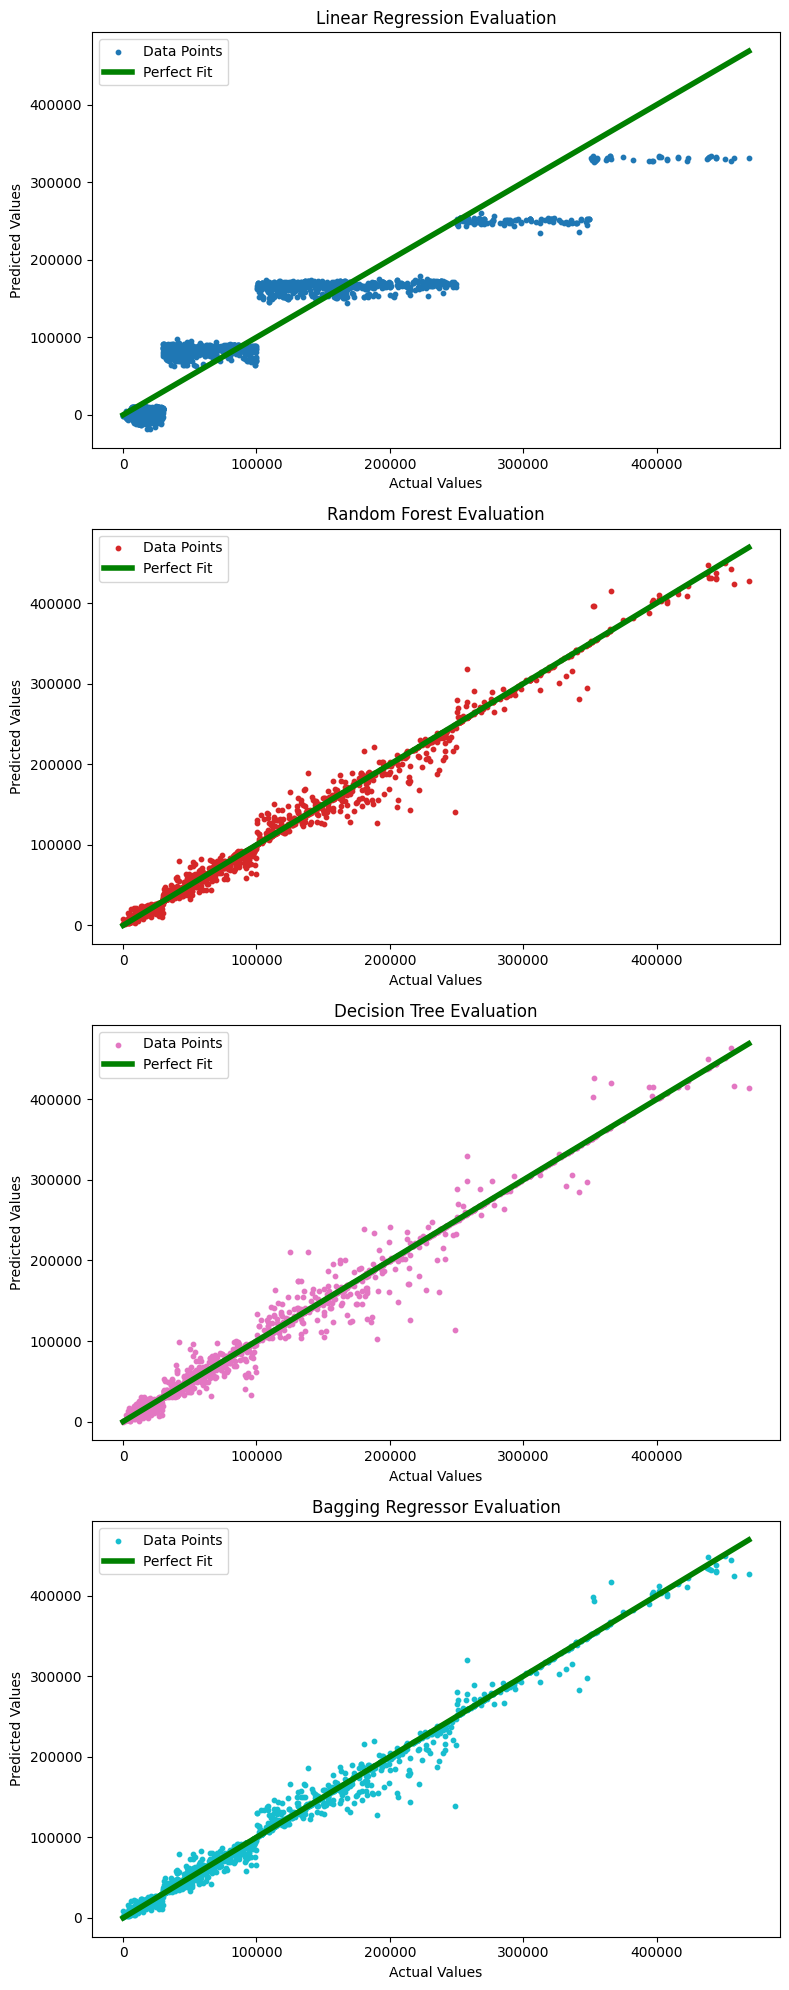

,Model,Accuracy,MSE,MAE,R2_score
0,Linear Regression,0.860424,995317653.956507,24732.271390,0.860424
1,Random Forest,0.992154,55950089.470028,3068.754234,0.992154
2,Decision Tree,0.988305,83397741.944071,3045.011681,0.988305
3,Bagging Regressor,0.992216,55509890.612615,3042.852583,0.992216


In [ ]:
results = []

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=1812)),
    ('Decision Tree', DecisionTreeRegressor(random_state=1812)),
    ('Bagging Regressor', BaggingRegressor(n_estimators=150, random_state=1812))
]

num_models = len(models)
fig, axes = plt.subplots(num_models, 1, figsize=(8, 5 * num_models))

colors = plt.cm.get_cmap('tab10', num_models)

for idx, (name, model) in enumerate(models):
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)
    accuracy = model.score(X_test_sc, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, MAE, R2_score))

    acc_train = model.score(X_train_sc, y_train) * 100
    acc_test = model.score(X_test_sc, y_test) * 100

    print(f'The accuracy of the {name} Model Train is {acc_train:.2f}')
    print(f'The accuracy of the {name} Model Test is {acc_test:.2f}')

    scatter = axes[idx].scatter(y_test, y_pred, s=10, c=[colors(idx)], label='Data Points')
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{name} Evaluation')
    axes[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linewidth=4, label='Perfect Fit')
    axes[idx].legend()

plt.tight_layout()
plt.show()

dff = pd.DataFrame(results, columns=['Model', 'Accuracy', 'MSE', 'MAE', 'R2_score'])
df_styled_best = dff.style.highlight_max(subset=['Accuracy', 'R2_score'], color='green').highlight_min(
    subset=['MSE'], color='green').highlight_max(subset=['MSE'], color='red').highlight_min(subset=['MAE'],
                                                                                                color='green').highlight_max(
    subset=['MAE'], color='red').highlight_min(subset=['Accuracy', 'R2_score'], color='red')
display(df_styled_best)


<ipython-input-61-98c1f478f2e3>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_models)


The accuracy of the Linear Regression Model Train is 85.72
The accuracy of the Linear Regression Model Test is 86.04
The accuracy of the Random Forest Model Train is 99.90
The accuracy of the Random Forest Model Test is 99.22


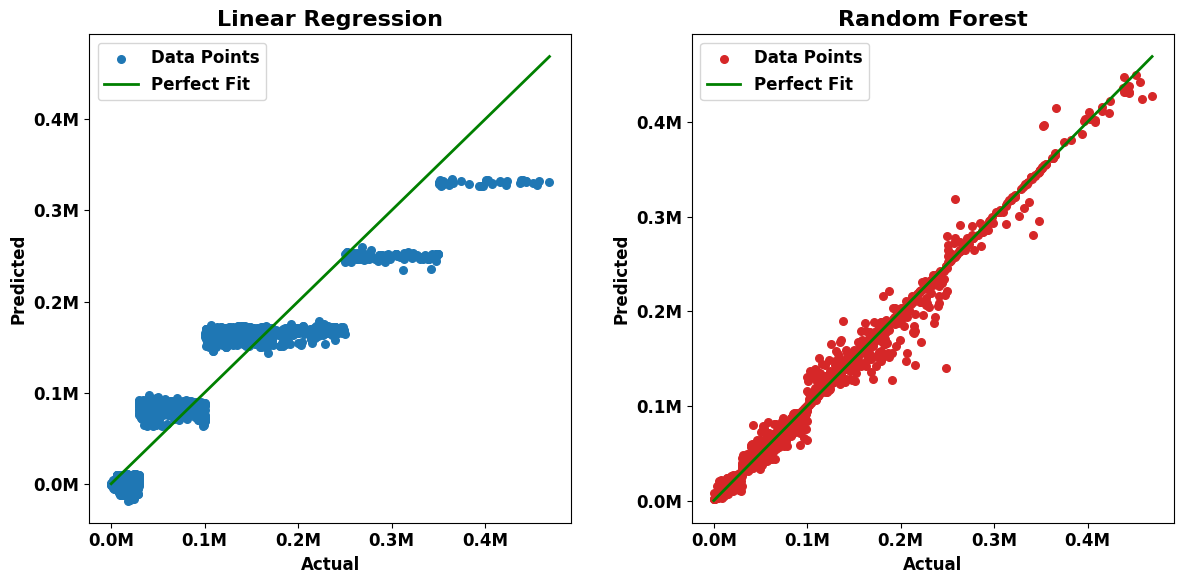

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

results = []

# Define the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=1812)),
    ('Decision Tree', DecisionTreeRegressor(random_state=1812)),
    ('Bagging Regressor', BaggingRegressor(n_estimators=150, random_state=1812))
]

num_models = len(models)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = plt.cm.get_cmap('tab10', num_models)

def format_func(value, tick_number):
    return f'{value/1000000:.1f}M'

for idx, (name, model) in enumerate(models[:2]):
    y_pred = model.predict(X_test_sc)
    accuracy = model.score(X_test_sc, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, MAE, R2_score))

    acc_train = model.score(X_train_sc, y_train) * 100
    acc_test = model.score(X_test_sc, y_test) * 100

    print(f'The accuracy of the {name} Model Train is {acc_train:.2f}')
    print(f'The accuracy of the {name} Model Test is {acc_test:.2f}')

    scatter = axes[idx].scatter(y_test, y_pred, s=30, c=[colors(idx)], label='Data Points')
    axes[idx].set_xlabel('Actual', fontweight='semibold')
    axes[idx].set_ylabel('Predicted', fontweight='semibold')
    axes[idx].set_title(f'{name}', fontsize=14)
    axes[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linewidth=2, label='Perfect Fit')
    axes[idx].legend()

    axes[idx].xaxis.set_major_formatter(FuncFormatter(format_func))
    axes[idx].yaxis.set_major_formatter(FuncFormatter(format_func))

axes[0].title.set_fontsize(16)
axes[0].title.set_fontweight('demibold')
axes[1].title.set_fontsize(16)
axes[1].title.set_fontweight('demibold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()


The accuracy of the Decision Tree Model Train is 100.00
The accuracy of the Decision Tree Model Test is 98.83
The accuracy of the Bagging Regressor Model Train is 99.90
The accuracy of the Bagging Regressor Model Test is 99.22


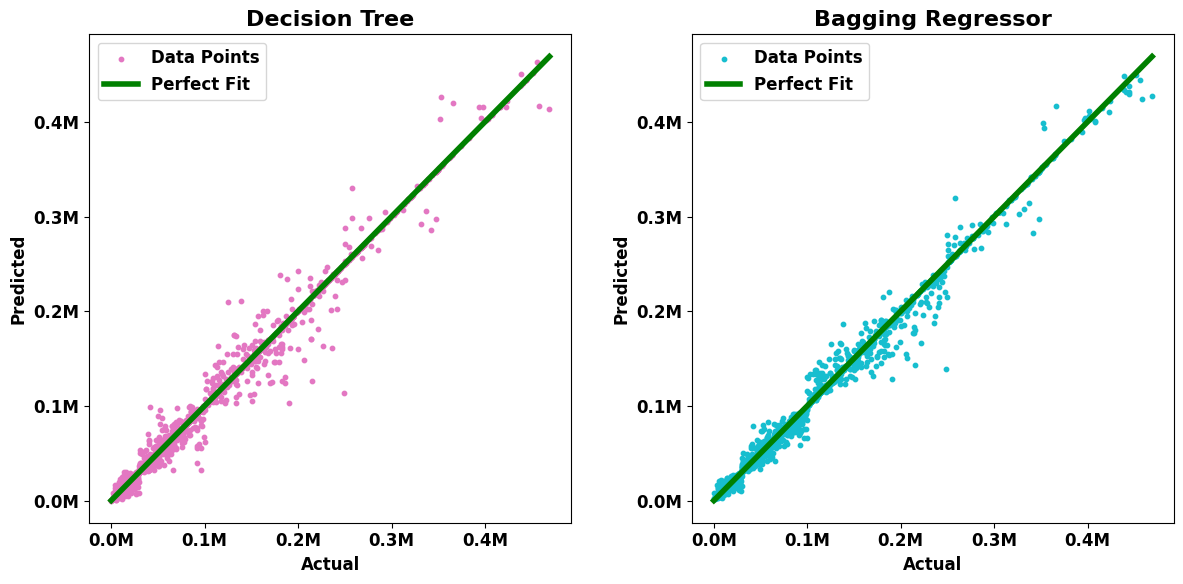

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for idx, (name, model) in enumerate(models[2:]):
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)
    accuracy = model.score(X_test_sc, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, MAE, R2_score))

    acc_train = model.score(X_train_sc, y_train) * 100
    acc_test = model.score(X_test_sc, y_test) * 100

    print(f'The accuracy of the {name} Model Train is {acc_train:.2f}')
    print(f'The accuracy of the {name} Model Test is {acc_test:.2f}')

    scatter = axes[idx].scatter(y_test, y_pred, s=10, c=[colors(idx+2)], label='Data Points')
    axes[idx].set_xlabel('Actual', fontweight='bold')
    axes[idx].set_ylabel('Predicted', fontweight='bold')
    axes[idx].set_title(f'{name}', fontsize=16, fontweight='bold')
    axes[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linewidth=4, label='Perfect Fit')
    axes[idx].legend()

    axes[idx].xaxis.set_major_formatter(FuncFormatter(format_func))
    axes[idx].yaxis.set_major_formatter(FuncFormatter(format_func))

axes[0].title.set_fontsize(16)
axes[0].title.set_fontweight('demibold')
axes[1].title.set_fontsize(16)
axes[1].title.set_fontweight('demibold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
for name, model in models:
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)
    model_rmses = -cross_val_score(model, X_test_sc, y_test,
    scoring="neg_root_mean_squared_error", cv=10)
    print (f'CROSS VALIDATION {name} MODEL')
    print (pd.Series(model_rmses).describe())

CROSS VALIDATION Linear Regression MODEL
count       10.000000
mean     31531.163935
std        890.328201
min      30584.288508
25%      30769.669061
50%      31461.541835
75%      32065.567962
max      33348.027967
dtype: float64
CROSS VALIDATION Random Forest MODEL
count       10.000000
mean     14810.829438
std       1845.322932
min      11119.542600
25%      13979.247620
50%      15094.008416
75%      15972.676856
max      17376.587297
dtype: float64
CROSS VALIDATION Decision Tree MODEL
count       10.000000
mean     19150.123645
std       2175.688864
min      15845.430549
25%      17446.561971
50%      19184.817338
75%      20398.836597
max      22638.602439
dtype: float64
CROSS VALIDATION Bagging Regressor MODEL
count       10.000000
mean     14778.604033
std       1810.190864
min      11129.934093
25%      14040.211374
50%      15060.858905
75%      15897.576416
max      17350.876832
dtype: float64
